# Atlantic Northward Heat Transport

This notebook uses the `T_ady_2d` diagnostic from MOM6 and compares with observations.<br>
(Note: For models that use neutral diffusion, this notebook may need futher modification.)

In [1]:
import glob
import itertools
import os
import subprocess

import cmip_basins
import doralite

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import momgrid as mg
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Load runtime parameters

In [2]:
# Configuration dictionary. Edit values here. If running from Dora,
# they will be overwritten at runtime.
config = {
    "startyr": "1",
    "endyr": "60",
    "dora_id": "odiv-1",
    "pathPP": "",
}

for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"] if f"MAR_{k.upper()}" in os.environ.keys() else v
    )

In [3]:
# Create a list of experiments to consider
experiments = [doralite.dora_metadata(x) for x in config["dora_id"].split(",")]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

### Determine what files to load

In [4]:
def is_in_range(file,start,end):
    """Function determines if a candidate netcdf file is
    within the requested date range"""
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [5]:
datafiles = []
staticfiles = []

for experiment in experiments:
    _pathPP = experiment["pathPP"]

    # Workaround for different pp structure in OM4
    if experiment["requested_id"] == "odiv-1":
        possible_components = ["ocean_monthly"]
    else:
        possible_components = ["ocean_annual", "ocean_monthly"]

    for component in possible_components:
        static = f"{component}/{component}.static.nc"
        varname = "ann"

        chunk = "5yr"
        filelist = sorted(
            glob.glob(
                f"{_pathPP}{component}/av/annual_{chunk}/{component}.*.{varname}.nc"
            )
        )

        filelist = [x for x in filelist if is_in_range(x, start, end)]
        _staticfile = f"{_pathPP}/{static}"

        if len(filelist) > 0:
            staticfiles.append(_staticfile)
            datafiles.append(filelist) 
            break

    if len(filelist) == 0:
        print(f"No files found, skipping experiment {experiment['expName']}")
        experiments.remove(experiment)

allfiles = sorted(list(itertools.chain(*datafiles)) + staticfiles)
_ = [print(x) for x in allfiles]

/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp//ocean_monthly/ocean_monthly.static.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly/av/annual_5yr/ocean_monthly.0001-0005.ann.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly/av/annual_5yr/ocean_monthly.0006-0010.ann.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly/av/annual_5yr/ocean_monthly.0011-0015.ann.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly/av/annual_5yr/ocean_monthly.0016-0020.ann.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly/av/annual_5yr/ocean_monthly.0021-0025.ann.nc
/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1

In [6]:
# This cell will call `dmget` on the files if run interactively
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+allfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Calculate the Northward Heat Transport for each experiment

The Atlantic basin northward heat transport is calculated for each candidate
experiment and stored in the `results` list

In [7]:
atl_results = []
gbl_results = []

for n, exp in enumerate(experiments):
    ds = mg.Gridset(datafiles[n]).data
    var = ds["T_ady_2d"]
    ds = xr.Dataset({var.name: var})
    ds = ds.mean("time")

    # Nominal Latitude for plotting
    lat = ds.geolat_v.mean("xh")

    # Global
    result = ds["T_ady_2d"].sum("xh")
    result = result.assign_coords({"yq": lat.values})
    result = result.rename({"yq": "lat"})

    # Convert to PW
    result = result * 1.e-15 
    gbl_results.append(result.load())

    # Atlantic
    mask = cmip_basins.generate_basin_codes(ds, lon="geolon_v", lat="geolat_v")
    mask = xr.where(
        (mask == 2)
        | (mask == 4)
        | (mask == 6)
        | (mask == 7)
        | (mask == 8)
        | (mask == 9),
        1,
        0,
    )

    result = (ds["T_ady_2d"] * mask).sum("xh")
    result = result.assign_coords({"yq": lat.values})
    result = result.rename({"yq": "lat"})

    # Convert to PW
    result = result * 1.e-15 
    atl_results.append(result.load())

### Make a plot with the results

In [8]:
# Trenberth and Caron Obs.
dsobs = xr.open_dataset("/archive/jpk/om4labs/datasets/Trenberth_and_Caron/Trenberth_and_Caron_Heat_Transport.nc")

yobs = dsobs.ylat.values
NCEP_Global = dsobs.OTn.values
NCEP_Atlantic = dsobs.ATLn.values
NCEP_IndoPac = dsobs.INDPACn.values
ECMWF_Global = dsobs.OTe.values
ECMWF_Atlantic = dsobs.ATLe.values
ECMWF_IndoPac = dsobs.INDPACe.values

In [9]:
# Ganachaud, A. and C. Wunsch Obs.

class GWObs:
    class _gw:
        def __init__(self, lat, trans, err):
            self.lat = lat
            self.trans = trans
            self.err = err
            self.minerr = trans - err
            self.maxerr = trans + err

        def annotate(self, ax):
            for n in range(0, len(self.minerr)):
                if n == 0:
                    ax.plot(
                        [self.lat[n], self.lat[n]],
                        [self.minerr[n], self.maxerr[n]],
                        "c",
                        linewidth=2.0,
                        label="G&W",
                    )
                else:
                    ax.plot(
                        [self.lat[n], self.lat[n]],
                        [self.minerr[n], self.maxerr[n]],
                        "c",
                        linewidth=2.0,
                    )
                ax.scatter(self.lat, self.trans, marker="s", facecolor="cyan")

    def __init__(self):
        self.gbl = self._gw(
            np.array([-30.0, -19.0, 24.0, 47.0]),
            np.array([-0.6, -0.8, 1.8, 0.6]),
            np.array([0.3, 0.6, 0.3, 0.1]),
        )
        self.atl = self._gw(
            np.array([-45.0, -30.0, -19.0, -11.0, -4.5, 7.5, 24.0, 47.0]),
            np.array([0.66, 0.35, 0.77, 0.9, 1.0, 1.26, 1.27, 0.6]),
            np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09]),
        )
        self.indpac = self._gw(
            np.array([-30.0, -18.0, 24.0, 47.0]),
            np.array([-0.9, -1.6, 0.52, 0.0]),
            np.array(
                [
                    0.3,
                    0.6,
                    0.2,
                    0.05,
                ]
            ),
        )

GW = GWObs()

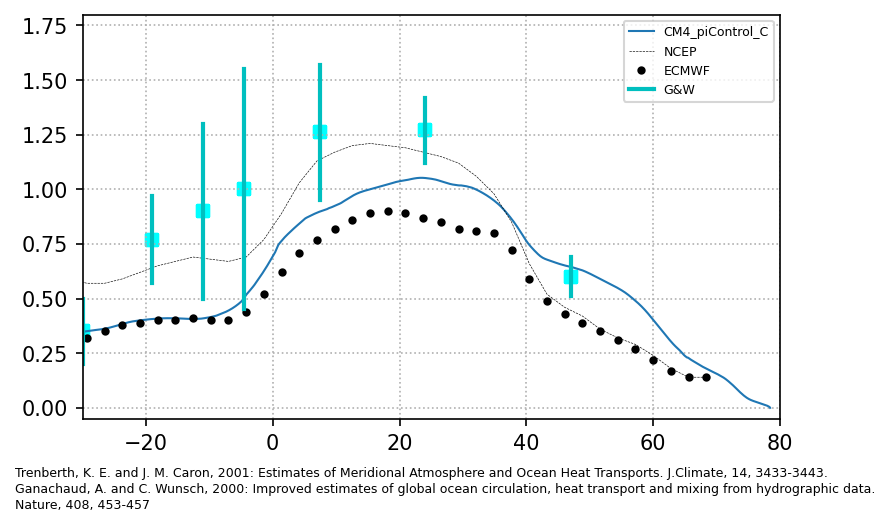

In [10]:
fig = plt.figure(figsize=(6, 3.5), dpi=150)
ax = plt.subplot(1, 1, 1)
for n, exp in enumerate(experiments):
    result = atl_results[n]
    ax.plot(result.lat, result.values, linewidth=1.0, label=exp["expName"])
ax.plot(yobs, NCEP_Atlantic, "k--", linewidth=0.3, label="NCEP")
ax.plot(yobs, ECMWF_Atlantic, "k.", linewidth=0.3, label="ECMWF")
GW.atl.annotate(ax)
ax.set_xlim(-30, 80)
ax.set_ylim(-0.05, 1.8)
plt.grid(True, linestyle=":")
plt.legend(fontsize=6)

# Annotations
_ = fig.text(
    0.05,
    0.00,
    r"Trenberth, K. E. and J. M. Caron, 2001: Estimates of Meridional Atmosphere and Ocean Heat Transports. J.Climate, 14, 3433-3443.",
    fontsize=6,
)
_ = fig.text(
    0.05,
    -0.03,
    r"Ganachaud, A. and C. Wunsch, 2000: Improved estimates of global ocean circulation, heat transport and mixing from hydrographic data.",
    fontsize=6,
)
_ = fig.text(0.05, -0.06, r"Nature, 408, 453-457", fontsize=6)

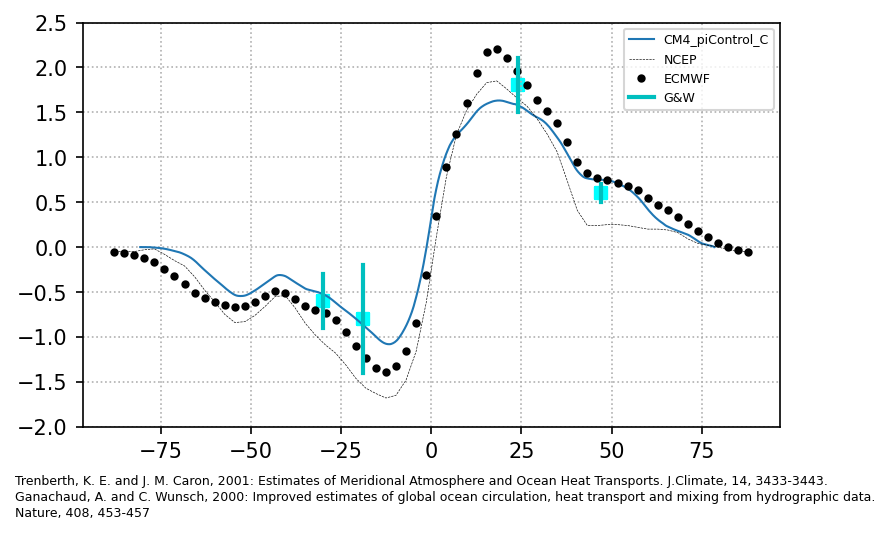

In [11]:
fig = plt.figure(figsize=(6, 3.5), dpi=150)
ax = plt.subplot(1, 1, 1)
for n, exp in enumerate(experiments):
    result = gbl_results[n]
    ax.plot(result.lat, result.values, linewidth=1.0, label=exp["expName"])
ax.plot(yobs, NCEP_Global, "k--", linewidth=0.3, label="NCEP")
ax.plot(yobs, ECMWF_Global, "k.", linewidth=0.3, label="ECMWF")
GW.gbl.annotate(ax)
#ax.set_xlim(-30, 80)
ax.set_ylim(-2, 2.5)
plt.grid(True, linestyle=":")
plt.legend(fontsize=6)

# Annotations
_ = fig.text(
    0.05,
    0.00,
    r"Trenberth, K. E. and J. M. Caron, 2001: Estimates of Meridional Atmosphere and Ocean Heat Transports. J.Climate, 14, 3433-3443.",
    fontsize=6,
)
_ = fig.text(
    0.05,
    -0.03,
    r"Ganachaud, A. and C. Wunsch, 2000: Improved estimates of global ocean circulation, heat transport and mixing from hydrographic data.",
    fontsize=6,
)
_ = fig.text(0.05, -0.06, r"Nature, 408, 453-457", fontsize=6)